In [2]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
import torch
import sys
import glob
import os
import cv2
import time
import math

from PIL import Image
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label, sum as ndimage_sum

from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.feature import canny

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

sam_checkpoint = "/home/wsl/bin/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker=".", s=marker_size, edgecolor="black", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker=".", s=marker_size, edgecolor="black", linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0,0,0,0), lw=2))    

Processing File 001/189:	Round01-Hive01-2024_06_05-h01bee01.JPG


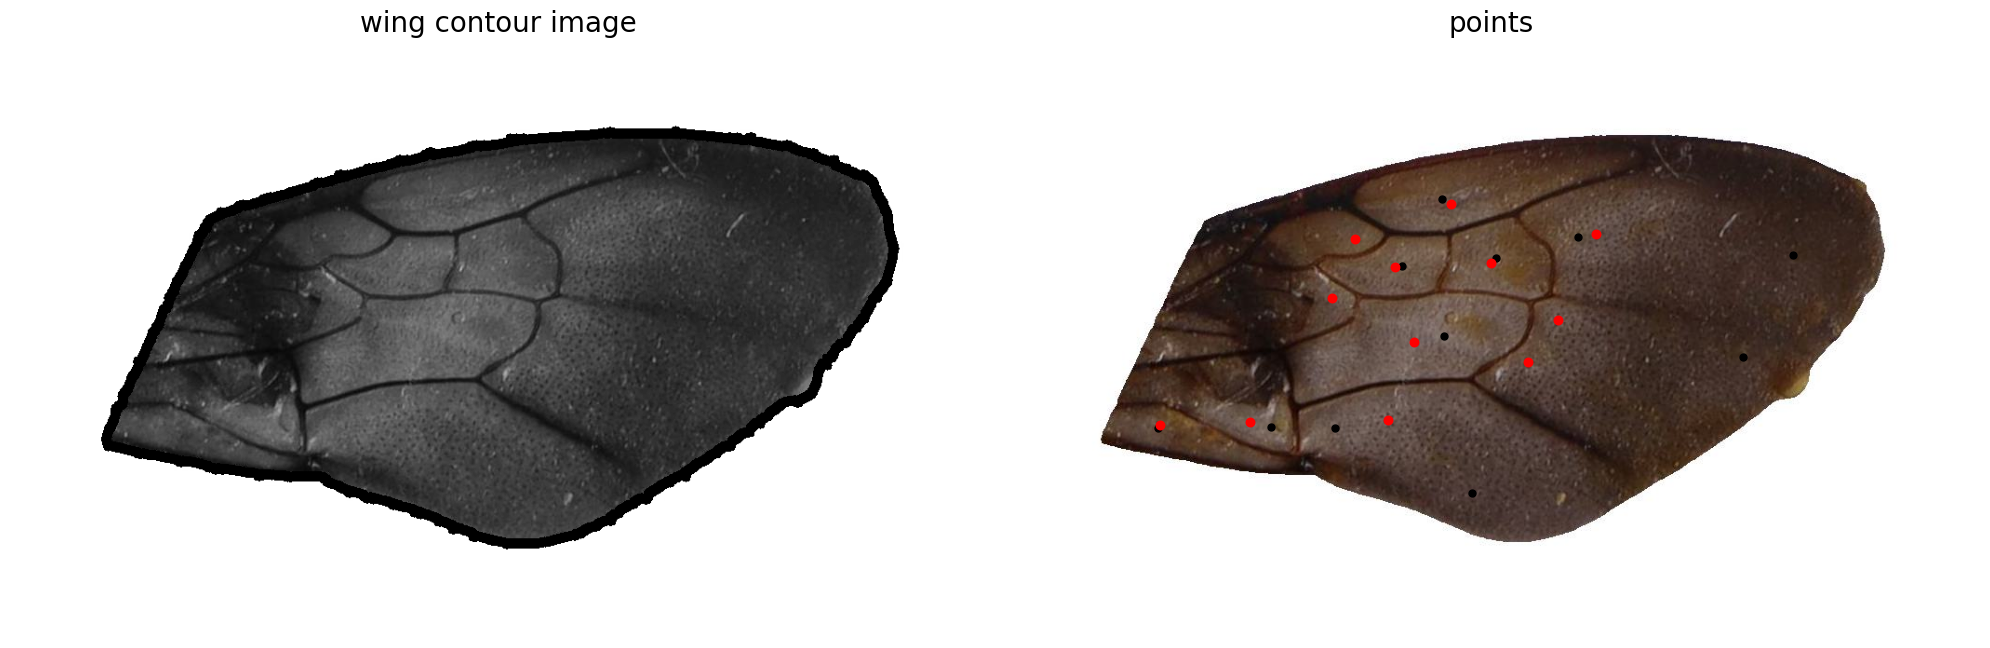

[(169, 414), (266, 410), (414, 408), (564, 346), (597, 301), (442, 324), (354, 277), (421, 244), (378, 214), (525, 239), (638, 208), (482, 176)]


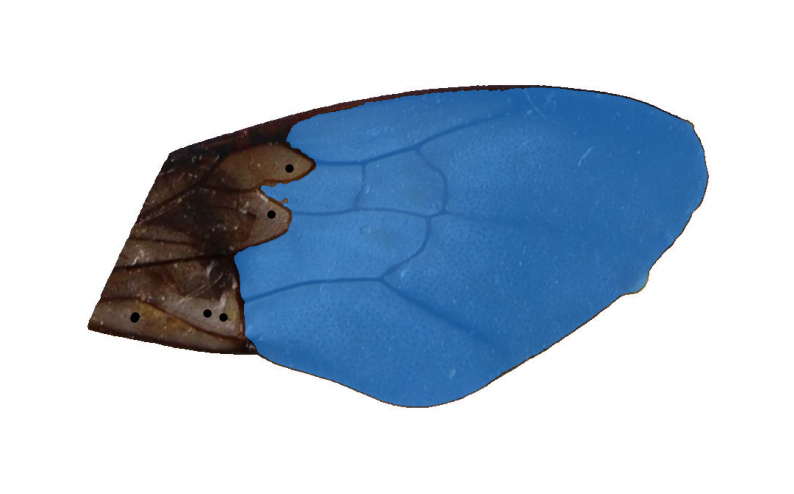

(167, 417)
(169, 414)
(266, 410)
(288, 416)
(354, 277)
(378, 214)
Processing File 002/189:	Round01-Hive01-2024_06_05-h01bee16.JPG


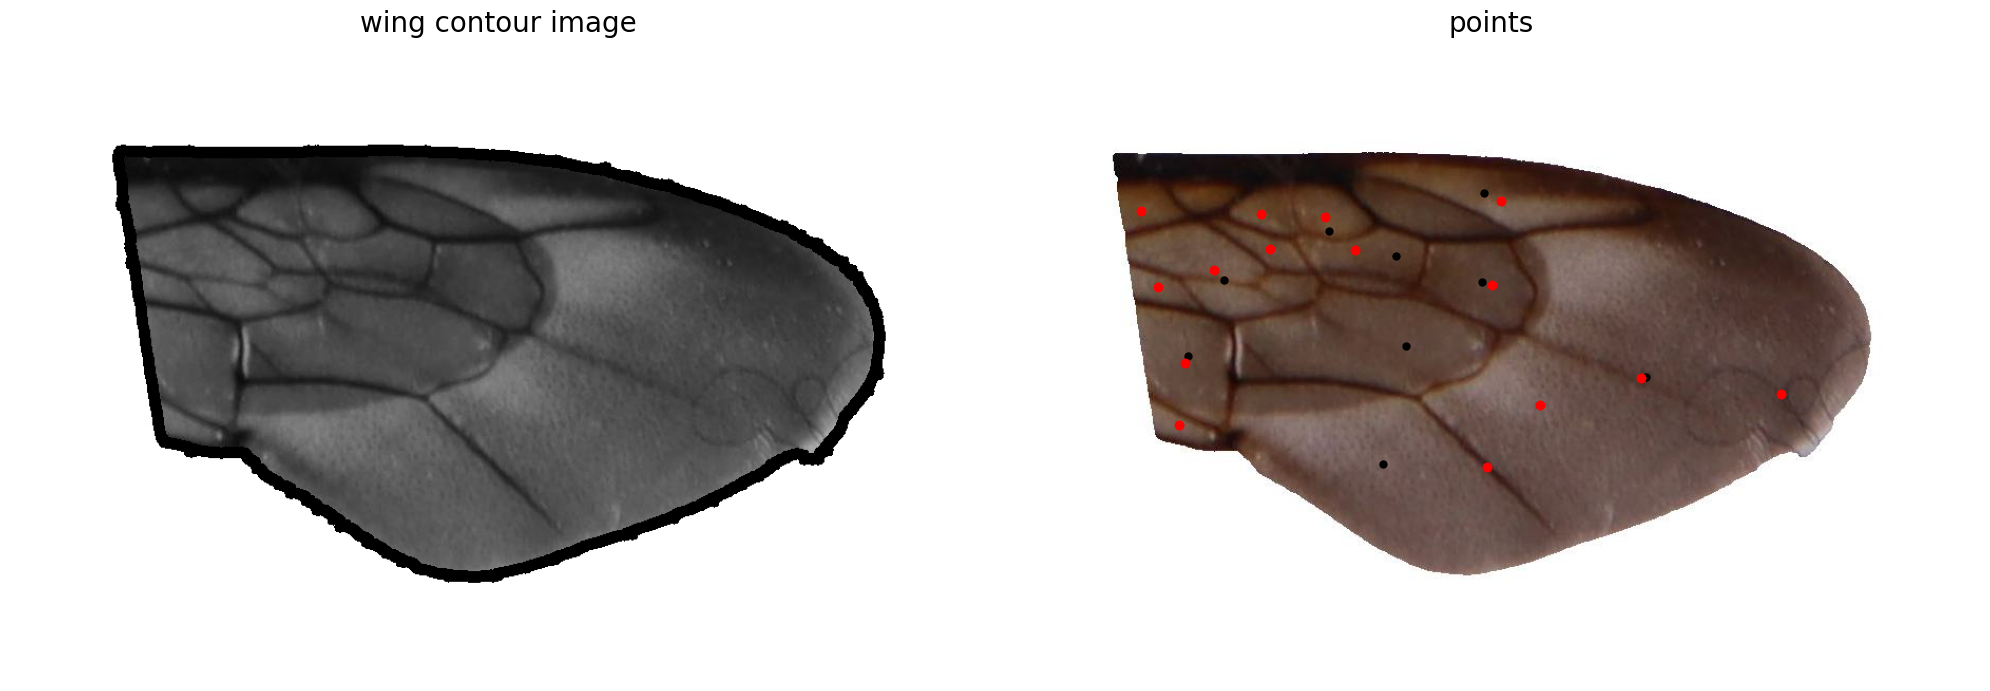

[(167, 365), (173, 306), (147, 234), (464, 232), (334, 199), (509, 346), (459, 405), (738, 335), (605, 320), (253, 198), (200, 218), (245, 165), (131, 162), (305, 167), (472, 152)]


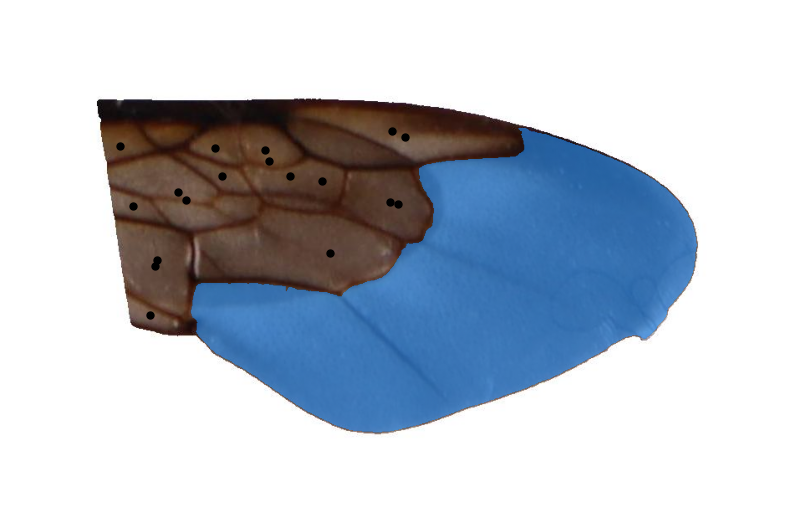

(131, 162)
(147, 234)
(167, 365)


KeyboardInterrupt: 

In [11]:
def find_black_area(image, window_size):
    h, w = image.shape
    max_density = -1
    best_coords = (0, 0)

    # Slide the window over the image
    for y in range(0, h - window_size[1] + 1, 1):
        for x in range(0, w - window_size[0] + 1, 1):
            # Extract the window from the image
            window = image[y:y + window_size[1], x:x + window_size[0]]

            # Count the number of black pixels (assuming black pixels are 0)
            black_pixel_count = np.sum(window == 0)

            # Track the window with the maximum number of black pixels
            if black_pixel_count > max_density:
                max_density = black_pixel_count
                best_coords = (x, y)

    return best_coords


def find_lowest_and_right_points(contour):
    # Convert contour to a 2D array
    contour_points = contour[:, 0, :]

    # Find the lowest point (maximum y-coordinate)
    lowest_point_index = np.argmax(contour_points[:, 1])
    lowest_point = contour_points[lowest_point_index]

    # Find the rightmost point (maximum x-coordinate)
    right_point_index = np.argmax(contour_points[:, 0])
    right_point = contour_points[right_point_index]

    return tuple(lowest_point), tuple(right_point)


def find_wing_contour(gray):
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding to get a binary image
    _, wing_thresh = cv2.threshold(blurred_image, 250, 255, cv2.THRESH_BINARY)

    # Invert the binary image
    wing_inv_thresh = cv2.bitwise_not(wing_thresh)

    # Find contour
    all_wing_contours, _ = cv2.findContours(wing_inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour based on area
    wing_contour = max(all_wing_contours, key=cv2.contourArea)
    
    # Calculate wing area
    wing_area = cv2.contourArea(wing_contour)
    
    wing_contour_image = gray.copy()
    cv2.drawContours(wing_contour_image, all_wing_contours, -1, (0), 10)

    return wing_contour, wing_contour_image
    

def find_initial_segment_contours(wing_contour_image, image):
    # Initialize variables to track the best threshold
    max_contours = 0
    best_percentage_covered = 0
    best_centroids = []
    best_contour_image = None
    best_threshold = None

    threshold = 250
    while threshold >= 0:
        # Apply thresholding to get a binary image
        _, segments_thresh = cv2.threshold(wing_contour_image, threshold, 255, cv2.THRESH_BINARY)
    
        # Invert the binary image
        segments_inv_thresh = cv2.bitwise_not(segments_thresh)
        
        # Find contour
        # all_segments_contours, _ = cv2.findContours(segments_inv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
        # Find contours with RETR_TREE to get hierarchy
        all_segments_contours, hierarchy = cv2.findContours(segments_inv_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
        # Filter only internal contours
        internal_contours = [all_segments_contours[i] for i in range(len(all_segments_contours)) if hierarchy[0][i][3] != -1]

        # Filter out small contours
        large_segment_contours = [cnt for cnt in internal_contours if (cv2.contourArea(cnt) > 1000)]

        if len(large_segment_contours) > 0:
            # Initialize total area and centroids
            total_area = 0
            centroids = []
    
            # Create a copy of the image for drawing
            segments_contour_image = image.copy()
    
            # Process each contour
            for contour in large_segment_contours:
                # Calculate area
                contour_area = cv2.contourArea(contour)
                total_area += contour_area
    
                # Calculate centroid
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append((cx, cy))
    
                # Draw the contour
                color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
                cv2.drawContours(segments_contour_image, [contour], -1, color, thickness=cv2.FILLED)
    
            # Calculate percentage covered
            wing_area = gray.shape[0] * gray.shape[1]
            percentage_covered = (total_area / wing_area) * 100
    
            # print(f"  Number of segments: {len(large_segment_contours)}")
            # print(f"  Percentage of area covered: {percentage_covered:.2f}%")
    
            # Update the best image based on criteria
            if (len(large_segment_contours) > max_contours) or (len(large_segment_contours) == max_contours and percentage_covered > best_percentage_covered):
                best_threshold = threshold
                max_contours = len(large_segment_contours)
                best_percentage_covered = percentage_covered
                best_centroids = centroids
                best_contour_image = segments_contour_image

        # Decrease threshold until 0 is reached 
        threshold -= 1

    return best_centroids, best_threshold


def find_local_max(wing_contour_image, best_threshold):
    _, threshold_image = cv2.threshold(wing_contour_image, best_threshold-20, 255, cv2.THRESH_BINARY)
    
    binary_image = threshold_image < 128

    dt = distance_transform_edt(~binary_image)

    local_max = peak_local_max(dt, min_distance=40)

    return local_max
    

def sam_predict_mask(image, input_points, input_labels):
    predictor.set_image(image)

    masks, scores, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=False,
    )
    
    return masks[0]


def postprocess_mask(mask):
    labeled_mask, num_features = label(mask)
    if num_features == 0: 
        return mask
    component_sizes = ndimage_sum(mask, labeled_mask, range(1, num_features + 1))
    largest_component_label = np.argmax(component_sizes) + 1 
    largest_component_mask = labeled_mask == largest_component_label
    clean_mask = binary_fill_holes(largest_component_mask)
    
    return clean_mask
    

def segmentation(gray, image):
    wing_contour, wing_contour_image = find_wing_contour(gray)
    centroids, best_threshold = find_initial_segment_contours(wing_contour_image, image)
    local_max = find_local_max(wing_contour_image, best_threshold)

    # Convert the array to a list of coordinates
    local_max = [tuple(coord) for coord in local_max]
    local_max = [(y, x) for x, y in local_max]
    
    local_max_x = [cx for cx, cy in local_max]
    local_max_y = [cy for cx, cy in local_max]
    centroids_x = [cx for cx, cy in centroids]
    centroids_y = [cy for cx, cy in centroids]

    # Create a 1x2 figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    # Image 1
    axes[0].imshow(wing_contour_image, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(f"wing contour image", size=20)
    # Image 2
    axes[1].imshow(image)
    axes[1].scatter(local_max_x, local_max_y, c="black", s=100, marker=".")
    axes[1].scatter(centroids_x, centroids_y, c="red", s=150, marker=".")
    axes[1].set_title(f"points", size=20)
    axes[1].axis("off")

    # Show the figure
    plt.tight_layout()
    plt.show()
    plt.close()

    print(centroids)
    # Merge the two lists
    centroids = centroids + local_max
    
    # Find forewing lobe points
    lowest_point, right_point = find_lowest_and_right_points(wing_contour)
    point_1 = (lowest_point[0], lowest_point[1] - 50)
    point_2 = (right_point[0] - 50, right_point[1])
    fwl_points = [point_1, point_2]
    
    # Sort coordinates by x-coordinate
    sorted_centroids = sorted(centroids, key=lambda coord: coord[0])

    # Negetive select left points
    select_points = 2
    pos_select = sorted_centroids[select_points:]
    neg_select = sorted_centroids[:select_points]

    input_points = np.array(neg_select + fwl_points)
    input_labels = np.array([0] * len(neg_select) + [1] * len(fwl_points))
        
    fwl_mask = sam_predict_mask(image, input_points, input_labels)
    fwl_mask = postprocess_mask(fwl_mask)

    # Remove points that are in the forewing lobe
    filtered_centroids = [(x, y) for x, y in sorted_centroids if not fwl_mask[y, x]]

    filtered_centroids_x = [cx for cx, cy in filtered_centroids]
    filtered_centroids_y = [cy for cx, cy in filtered_centroids]

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(fwl_mask, plt.gca())
    plt.scatter(filtered_centroids_x, filtered_centroids_y, c="black", s=100, marker=".")
    plt.axis("off")
    plt.show() 

    segment_masks = []
    
    for cord in filtered_centroids:
        print(cord)
        input_points = np.array(fwl_points + [cord])
        input_labels = np.array([0] * len(fwl_points) + [1])

        mask = sam_predict_mask(image, input_points, input_labels)
        mask = postprocess_mask(mask)
        segment_masks.append(mask)
            
    return segment_masks, fwl_mask
    

def remove_duplicate_masks(mask_list):
    mask_sizes = [np.sum(mask) for mask in mask_list]  # Calculate the size of each mask
    keep_masks = [True] * len(mask_list)  # Boolean list to track which masks to keep

    for i in range(len(mask_list)):
        for j in range(i + 1, len(mask_list)):
            if not keep_masks[i] or not keep_masks[j]:
                continue  # Skip if one of the masks is already marked for removal
            
            # Check for overlap
            overlap = np.logical_and(mask_list[i], mask_list[j])
            
            if np.any(overlap):  # If masks overlap
                if mask_sizes[i] >= mask_sizes[j]:
                    keep_masks[j] = False  # Remove smaller or equally sized mask
                else:
                    keep_masks[i] = False  # Remove current mask and keep the other

    # Return only the masks that are marked to keep
    return [mask for mask, keep in zip(mask_list, keep_masks) if keep]



# Start a timer 
start = time.time()


input_dir = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground_1/"
output_dir = "/mnt/c/Projects/Master/Data/Processed/4-LiveWingSegments/"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Find all jpg files
jpg_files = []
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".JPG") or file.endswith(".jpg"):
            jpg_files.append(os.path.join(root, file))

# Global warnings counter
total_warnings = 0

# Process every file
total_files = len(jpg_files)
digits = len(str(total_files))
for idx, jpg_file_path in enumerate(jpg_files, 1):
    jpg_basename = os.path.basename(jpg_file_path)
    output_file = output_dir + jpg_basename
    relative_jpg_path = jpg_file_path.removeprefix(input_dir)
    print(f"Processing File {idx:0{digits}}/{total_files}:\t{relative_jpg_path}")
    
    # Process image
    image = cv2.imread(jpg_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    segment_masks, fwl_mask = segmentation(gray, image)

    best_segment_masks = segment_masks
    best_segment_masks.append(fwl_mask)
    cleaned_mask_list = remove_duplicate_masks(best_segment_masks)
    
    # Create an empty RGBA image
    combined_masks = np.zeros((cleaned_mask_list[0].shape[0], cleaned_mask_list[0].shape[1], 4))  # 4 channels for RGBA
    
    # Loop through masks and add their color to the combined image
    for i, mask in enumerate(cleaned_mask_list):
        # Generate a random color in the range [0, 1] for RGB
        color = np.random.rand(3)
        # Apply the color to the mask (broadcasting over RGB channels)
        for c in range(3):  # RGB channels
            combined_masks[:, :, c] += mask * color[c]
    
    # Set alpha (transparency) channel: 1 where there's a mask, 0 otherwise
    combined_masks[:, :, 3] = np.sum(best_segment_masks, axis=0)  # Alpha = 1 where any mask is present
    combined_masks[:, :, 3] = np.clip(combined_masks[:, :, 3], 0, 1)  # Ensure alpha stays between 0 and 1
    
    # Clip the RGB values to ensure they're within [0, 1] range
    combined_masks[:, :, :3] = np.clip(combined_masks[:, :, :3], 0, 1)
    
    # Show the combined image
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.imshow(combined_masks, alpha=0.6)
    plt.axis("off")
    plt.savefig(output_file, bbox_inches="tight", pad_inches=0)
    plt.close()


# Print Total Warnings
print(f"\nTotal Warnings Across All Files: {total_warnings}")

# End the timer 
end = time.time()
duration = end - start

# Convert to hours, minutes, and seconds
hours = int(duration // 3600)
minutes = int((duration % 3600) // 60)
seconds = int(duration % 60)

# Print the runtime in hh:mm:ss format
print(f"Script Runtime (hh:mm:ss): {hours:02}:{minutes:02}:{seconds:02}")